# Observed omics allocation in RNA-Seq and Ribo-Seq

In [23]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# model = coralme.io.json.load_json_me_model("../ACCELERATE/models/pputida-2024_05_20/KT2440-UPF36-DLKcat-Transport10.json")

### Load predictions

In [25]:
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-R2A.csv",index_col=0)
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-M9.csv",index_col=0)
fluxes = pandas.read_csv("./datasets/predictions/KT2440-UPF36-M9.csv",index_col=0)

In [26]:
pred = fluxes[fluxes.index.str.contains("translation_")]["fluxes"]*1e9
pred.name = "predicted"
pred.index = [r.split("translation_")[-1] for r in pred.index]

### Load omics data

In [27]:
rna = pandas.read_csv("./datasets/omics/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [28]:
ribo = pandas.read_csv("./datasets/omics/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [29]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [30]:
def simplify(s):
    if isinstance(s,float):
        return s
    s = s.split("__")[-1]
    s = s.replace("S_","")
    s = s.replace("_"," ")
    s = s.replace("Metabolic:","")
    return s

In [31]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0).dropna(subset="subsystem")

In [32]:
Annotation["_subsystem"] = Annotation["subsystem"]
Annotation["subsystem"] = Annotation["subsystem"].apply(lambda x:simplify(x))

In [33]:
Annotation[Annotation["subsystem"]=="Biosynthesis"]

,locus_tag,name,description,type,length,subsystem,_subsystem
PP_0217,PP_RS01155,desA,delta-9 fatty acid desaturase DesA,CDS,1185.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0558,PP_RS02945,accC,acetyl-CoA carboxylase biotin carboxylase subunit,CDS,1356.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0559,PP_RS02950,accB,acetyl-CoA carboxylase biotin carboxyl carrier protein,CDS,462.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0922,PP_RS04850,NaN,ACP phosphodiesterase,CDS,585.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1607,PP_RS08290,NaN,acetyl-CoA carboxylase carboxyltransferase subunit alpha,CDS,948.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1913,PP_RS09855,fabD,ACP S-malonyltransferase,CDS,939.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1916,PP_RS09870,fabF,beta-ketoacyl-ACP synthase II,CDS,1245.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1996,PP_RS10355,accD,"acetyl-CoA carboxylase, carboxyltransferase subunit beta",CDS,894.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_2376,PP_RS12390,NaN,fatty acid cis/trans isomerase,CDS,2301.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_2734,PP_RS14230,NaN,cyclopropane-fatty-acyl-phospholipid synthase family protein,CDS,1263.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis


### Combine results

In [34]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te").join(pred)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem,_subsystem
PP_0001,115.346129,101.379836,117.392753,145.138868,205.633239,239.660650,0.794729,0.493013,0.489829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0010,649.987487,654.840617,574.275588,294.813326,365.693707,323.482848,2.204743,1.790681,1.775289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0097,20.691063,14.890996,21.743415,18.142359,64.468799,55.487934,1.140484,0.230980,0.391858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0947,32.817598,33.777137,39.853891,29.481333,23.342151,23.611887,1.113165,1.447045,1.687874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0948,14.117067,14.164606,29.334633,15.874564,17.784496,18.889509,0.889289,0.796458,1.552959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
# Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te").join(pred)
Results = pandas.concat([NormalizedRibo,
                         NormalizedRNA.rename(columns={s:s+"_rna" for s in samples}),
                         NormalizedTE.rename(columns={s:s+"_te" for s in samples}),
                         pred
                           ],
                           axis=1)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem,_subsystem
PP_0001,115.346129,101.379836,117.392753,145.138868,205.633239,239.660650,0.794729,0.493013,0.489829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0010,649.987487,654.840617,574.275588,294.813326,365.693707,323.482848,2.204743,1.790681,1.775289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0097,20.691063,14.890996,21.743415,18.142359,64.468799,55.487934,1.140484,0.230980,0.391858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0947,32.817598,33.777137,39.853891,29.481333,23.342151,23.611887,1.113165,1.447045,1.687874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0948,14.117067,14.164606,29.334633,15.874564,17.784496,18.889509,0.889289,0.796458,1.552959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
ResultsAnnotated.sort_values("PPutida_4_rna")

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem,_subsystem
PP_2055,11.445563,9.491496,14.640205,15.874564,12.226841,0.000000,0.721000,0.776284,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_3277,1.047649,2.251809,1.138683,6.803384,2.223062,0.000000,0.153989,1.012931,inf,0.000000e+00,PP_RS17100,paaB,"1,2-phenylacetyl-CoA epoxidase subunit PaaB",CDS,282.0,Phenylacetyl CoA Catabolom,Metabolic:S_Aromatic_Compounds_Degradation__Phenylacetyl_CoA_Catabolom
PP_3284,1.676238,1.598058,2.385811,6.803384,0.000000,0.000000,0.246383,inf,inf,0.000000e+00,PP_RS17135,paaF,"2,3-dehydroadipyl-CoA hydratase PaaF",CDS,774.0,Phenylacetyl CoA Catabolom,Metabolic:S_Aromatic_Compounds_Degradation__Phenylacetyl_CoA_Catabolom
PP_4488,3.457241,3.801441,3.144933,22.677948,4.446124,0.000000,0.152449,0.855001,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_3353,2.776269,2.736069,4.175170,13.606769,2.223062,0.000000,0.204036,1.230766,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_0168,9151.997729,9372.077945,10965.784486,12250.627612,15618.122402,16916.736223,0.747064,0.600077,0.648221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_mr18,NaN,NaN,NaN,16083.200856,67714.469911,42304.236799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_tm01,NaN,NaN,NaN,218558.725681,153192.317098,118689.870855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_0688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.108659e+04,NaN,NaN,NaN,NaN,NaN,Translation,Translation


In [37]:
ResultsGrouped = ResultsAnnotated[all_samples+["subsystem"]].groupby("subsystem").sum()

###  Totals

In [38]:
RiboMeans = ResultsGrouped[samples].mean(axis=1).sort_values(ascending=False)
RNAMeans = ResultsGrouped[rna_samples].mean(axis=1).sort_values(ascending=False)

In [39]:
RiboMeans

subsystem
Translation                                139010.549124
Transcription                               46888.831910
TCA Cycle                                   34612.872575
Oxidative Phosphorylation                   26357.589352
Purine Metabolism                           22443.573640
                                               ...      
Gallic acid Metabolism                         53.086610
Butanediol Metabolism                          26.611223
Levulinate Metabolism                          15.392035
Hydroxy proline metabolism                     15.347839
Aliphatic open-chain ketones metabolism         5.575402
Length: 92, dtype: float64

In [40]:
top = set(RiboMeans.head(10).index) | set(RNAMeans.head(10).index)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
color_dct = {i:c for i,c in zip(top,colors)}

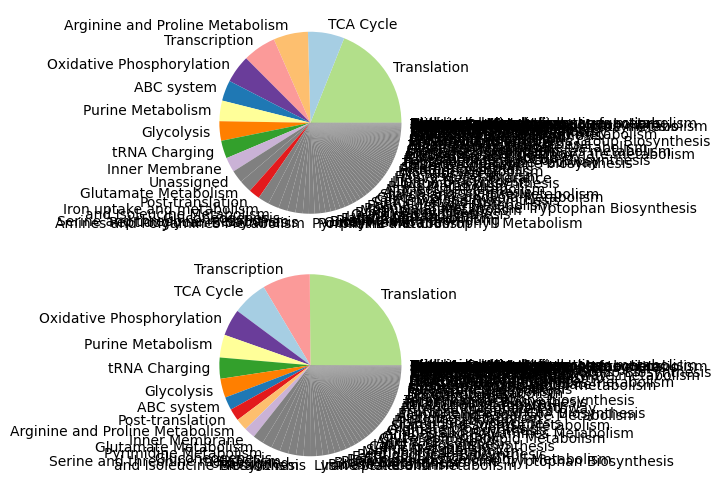

In [41]:
fig,ax = plt.subplots(2,1,figsize=(15,5))
RNAMeans.plot.pie(ax=ax[0],colors=[color_dct.get(i,"gray") for i in RNAMeans.index])
RiboMeans.plot.pie(ax=ax[1],colors=[color_dct.get(i,"gray") for i in RiboMeans.index])
fig.tight_layout()
fig.savefig("figures/ribo-rna-pathway-pie.svg",format="svg")

In [42]:
RiboMeans.head(20)

subsystem
Translation                        139010.549124
Transcription                       46888.831910
TCA Cycle                           34612.872575
Oxidative Phosphorylation           26357.589352
Purine Metabolism                   22443.573640
tRNA Charging                       20764.370743
Glycolysis                          18724.511149
ABC system                          12886.787348
Post-translation                    11923.405636
Arginine and Proline Metabolism     11711.232750
Inner Membrane                      10920.185676
Glutamate Metabolism                10442.957329
Pyrimidine Metabolism                9626.092101
Gluconeogenesis                      8724.901650
Serine and threonine metabolism      8435.689633
Unassigned                           7745.963701
and Isoleucine Metabolism            7316.344498
Biosynthesis                         6394.724057
Lysine Metabolism                    6291.405631
Iron uptake and metabolism           6239.391418
dtype: flo

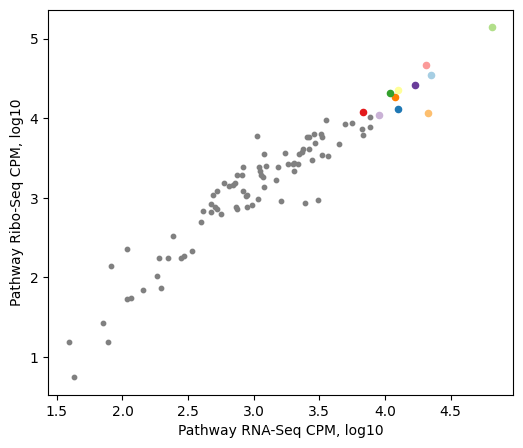

In [43]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
Means = pandas.concat([ResultsGrouped[samples].mean(axis=1).to_frame().rename(columns={0:"ribo"}),ResultsGrouped[rna_samples].mean(axis=1).to_frame().rename(columns={0:"rna"})],axis=1)
LogMeans = numpy.log10(Means)
# LogMeans.plot.scatter(x="rna",y="ribo",ax=ax)
for i,row in LogMeans.iterrows():
    s = 10
    if i in top:
        s = 20
    ax.scatter(x=row["rna"],y=row["ribo"],marker="o",s=s,color=color_dct.get(i,"gray"))
plt.xlabel("Pathway RNA-Seq CPM, log10")
plt.ylabel("Pathway Ribo-Seq CPM, log10")
fig.savefig("figures/ribo-rna-pathway-scatter.svg",format="svg")

### Correlation

In [44]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

PearsonRResult(statistic=0.940859929737588, pvalue=2.360614793832518e-81)


/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


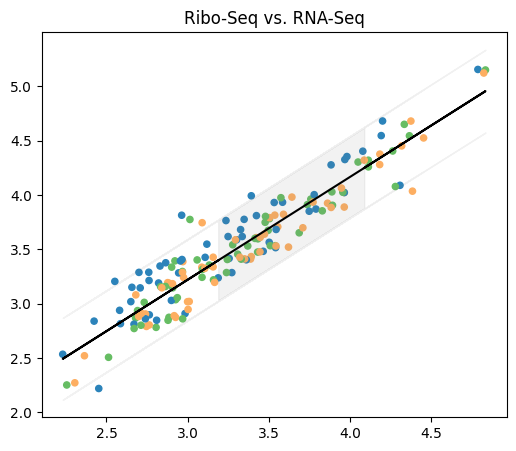

In [47]:
slist = samples
tmp = numpy.log10(ResultsGrouped).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = tmp[rna_samples].stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1,figsize=(6,5))
colors = ["#2b83ba","#66bd63","#fdae61"]
for i,row in tmp.iterrows():
    ax.scatter(x=row[rna_samples],y=row[samples],marker="o",s=s,color=colors)
plt.plot(X,est2.predict(),color="black")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
ax.fill_between(X,predict_ci_low,predict_ci_upp,color="gray",alpha=0.1)
plt.title("Ribo-Seq vs. RNA-Seq")

fig.savefig("figures/ribo-rna-pathway-correlation.svg",format="svg")